In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Import contents of pacakge
import posfai2 as my

ohe_spec_str: ".+0+1+2+3+4+0x1+0x2+1x2+1x3+2x3+2x4+3x4+0x1x2+1x2x3+2x3x4"
ohe_spec_str: .+0+1+2+3+4+0x1+0x2+1x2+1x3+2x3+2x4+3x4+0x1x2+1x2x3+2x3x4
x_ohe.shape: (325, 1)
sim_spec_str: .+.+0+.+1+.+2+.+3+.+4+.+0+1+0x1+.+0+2+0x2+.+1+2+1x2+.+1+3+1x3+.+2+3+2x3+.+2+4+2x4+.+3+4+3x4+.+0+1+0x1+2+0x2+1x2+0x1x2+.+1+2+1x2+3+1x3+2x3+1x2x3+.+2+3+2x3+4+2x4+3x4+2x3x4
x_test.shape: (325, 1)
Time for computation to complete: 0.015 sec.
M: 325
gamma: 165
T_exp @ T_fact @ x_ohe == x_dist for 10/10 seqs
T@T_inv == I: True
All 1,650 dot products between the 165 gauge vectors and the 10 one-hotencoded sequences are zero:  True
Unique elements of gauge basis [-1.  1.]


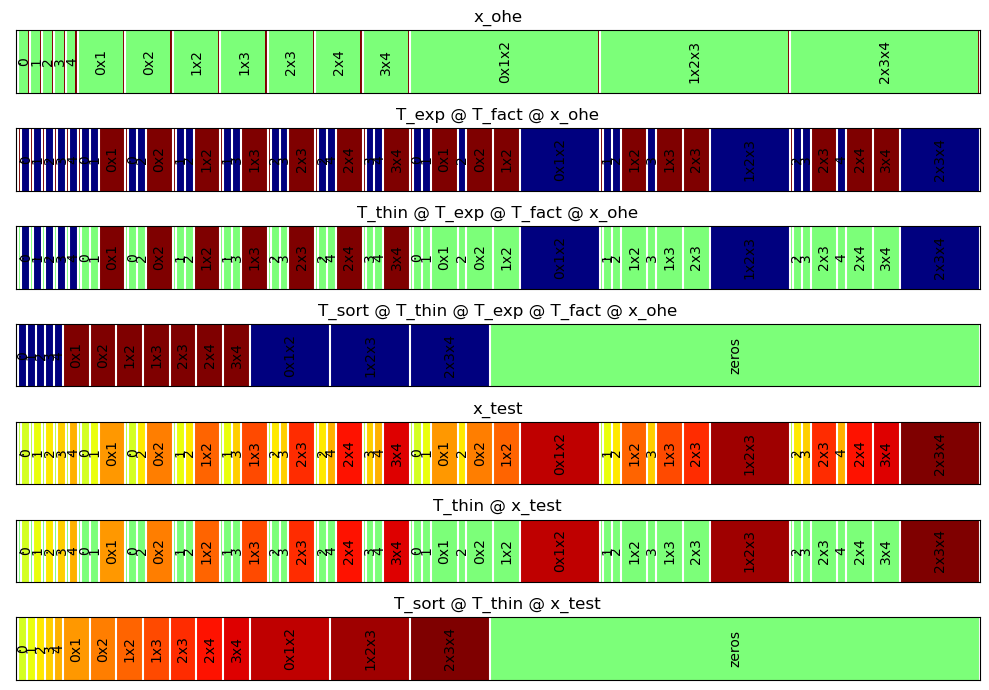

In [2]:
seq = 5*'T'
alphabet = 'ACGT'
ohe_spec_str = my.get_ohe_spec_str(L=len(seq), n_order=3, n_adj=3)
print(f'ohe_spec_str: "{ohe_spec_str}"')
info_dict = my.test_distillation(seq, 
                                 ohe_spec_str, 
                                 alphabet, 
                                 num_test_seqs=10,
                                 figsize=[10, 7], 
                                 show_vecs=True,
                                 show_annotations=True,
                                 show_xticks=False)